# Mount Google Drive and copy data
The files are located in my Google Drive folder. Using the *drive* library, my Google Driver folder is mounted, and the *hate speech dataset* is copied to the local folder of the Colab VM Machine.

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Copy files from drive to local machine
!cp -r /content/drive/MyDrive/Colab_Notebooks/hate-speech-dataset-master/ /content/data

# Change to folder
%cd /content/data
%ls /content/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/data
annotations_metadata.csv     sampled_test/
hate-speech-dataset-master/  sampled_train/


# Import the libraries

In [2]:
# For data handling and EDA
import pandas as pd
import numpy as np
# For Visualisation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# For NLP and ML
#import torch
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, f1_score
from sklearn.svm import LinearSVC
import nltk
from nltk.tokenize import word_tokenize

# Keras libraries
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Input, Flatten, Conv1D, MaxPooling1D, Concatenate
from keras.initializers import TruncatedNormal, Constant, glorot_uniform
#from keras.preprocessing import sequence

# Using the whole dataset
SKIP FOR NOW

## Load the whole dataset to Pandas

In [ ]:
# Load the annotations metadata csv to get label info
annot = pd.read_csv("hate-speech-dataset-master/annotations_metadata.csv")
# Keep only file id and label
annot.drop(columns=['user_id','subforum_id','num_contexts'],inplace=True)
# Add new empty column to insert the message
annot['message']=''
# Loop through all lines
for i in range(len(annot['file_id'])):
    # Get current filename
    filename = annot['file_id'][i]
    # Open the file and read the contents
    with open('hate-speech-dataset-master/all_files/' +filename +'.txt') as f:
        contents= f.read()
    f.close()
    # Add contents to the message column
    annot['message'][i]=contents
# Drop file id
annot.drop(columns=['file_id'],inplace=True)

### EDA and Pre-Processing

In [ ]:
# DataFrame information
annot.info()

In [ ]:
# Check the classes and their value counts
annot['label'].value_counts()

Based on the original paper, there are a total of 10944 sentences, 9507 of them are classified as no hate speech, 1196 are classified as hate speech, 168 are related to hate speech but depends on context of the forum post and 73 are non English sentences, classified as idk/skip. For the purpose of this research, relation and idk/skip classes will be dropped completely in order to make the problem a binary classification.

In [ ]:
# Keep sentences classified only as noHate and hate
cleanPosts = annot[(annot['label'] != 'relation') & (annot['label'] != 'idk/skip')]
# Reset index
cleanPosts=cleanPosts.reset_index(drop=True)

In [ ]:
# First 5 data points
cleanPosts.head(5)

In [ ]:
# Last 5 data points
cleanPosts.tail(5)

In [ ]:
# Update STOPWORDS
stop_words = STOPWORDS.update(["https", "S"])

In [ ]:
# WordCloud for posts classified as hate
wc_hate = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts['message'][cleanPosts['label']=='hate']))
# Generate plot
plt.imshow(wc_hate)
plt.axis("off")
plt.show()

In [ ]:
# WordCloud for posts classified as noHate
wc_noHate = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts['message'][cleanPosts['label']=='noHate']))
# Generate plot
plt.imshow(wc_noHate)
plt.axis("off")
plt.show()

### Pre-Process text with SpaCy

Before I proceed with the Bag of Words model, I need to pre-process the text (remove punctuations, stop words, lemmatize) in order to reduce the vocabulary size. I will use SpaCy for text pre-processing.

In [ ]:
# Get English words from NLTK
#nltk.download('words')
#words = set(nltk.corpus.words.words())
# Instantiate SpaCy's English module
nlp = spacy.load('en_core_web_sm')
# Remove default stop words and lemmatize each sentence
cleanPosts['clean_message'] = cleanPosts.message.apply(
    lambda text: 
        " ".join(
            token.lemma_.lower() for token in nlp(text)
                if token.lemma_.lower() not in nlp.Defaults.stop_words and token.is_alpha
                 #and token.lemma_.lower() in words
        )
)
# Drop old sentences
cleanPosts.drop(columns='message', inplace=True)

In [ ]:
# First 5 data points
cleanPosts.head(5)

In [ ]:
# Last 5 data points
cleanPosts.tail(5)

In [ ]:
# Check for empty strings and remove
cleanPosts[cleanPosts['clean_message'] == ''].count()

There are 233 empty entries after lemmatization and removing stop words, which I am going to remove.

In [ ]:
# Drop rows where 'clean_message' is an empty string
# Get index
idx = cleanPosts[cleanPosts['clean_message'] == ''].index
# Drop rows based on index
cleanPosts.drop(index=idx, inplace=True)

In [ ]:
# WordCloud for cleaned posts classified as hate
wc_hate_clean = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts['clean_message'][cleanPosts['label']=='hate']))
# Generate plot
plt.imshow(wc_hate_clean)
plt.axis("off")
plt.show()

In [ ]:
# WordCloud for cleaned posts classified as noHate
wc_noHate_clean = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts['clean_message'][cleanPosts['label']=='noHate']))
# Generate plot
plt.imshow(wc_noHate_clean)
plt.axis("off")
plt.show()

In [ ]:
# Plot the class distribution
plot = cleanPosts.label.value_counts().plot(kind='pie',autopct='%1.2f%%')

## Recreating Paper Results

### Support Vector Machines

#### Bag-of-Words Vectors

In [ ]:
# Instantiate Count Vectorizer
vectorizer = CountVectorizer()
# Vectorize
X = vectorizer.fit_transform(cleanPosts.clean_message.to_list())
X_bow = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names_out())

#### Split Dataset for SVM Model

In [ ]:
# Split dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_bow, cleanPosts.label, test_size=0.25, random_state=42, stratify=cleanPosts.label)

#### Classify text using SVM Model

Train the SVM Model

In [ ]:
# Instatiate SVC
svm = LinearSVC()
# Fit training data
svm.fit(X_train, y_train)
# Get prediction on test data
pred = svm.predict(X_test)

#### Get Accuracy and Confusion Matrix

In [ ]:
# Get the accuracy
print('Test Accuracy: '+str(svm.score(X_test, y_test)))
# Print the F1 Score
print('F1 Score: '+str(f1_score(y_test, pred, pos_label='hate')))
# Create confusion matrix
cm = confusion_matrix(y_test, pred, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()
plt.show()

Using all the available txt files with text pre-processing on a SVM Model returned an accuracy of 0.87 but an F1 Score of 0.48. This is because there is a big class inbalance in the training data. The SVM model does a really good job at classifying correctly the noHate sentences but handles poorly the hate sentences since more than half of them are missclassified.

# Using the sampled train and test dataset
The experiments of this research will be based on a balanced subset of labelled sentences, which is already provided by the dataset owner in the *sampled_train* and *sampled_test* folders. According to the dataset owner, "All the sentences labelled as **hate** have been collected, and an equivalent number of **noHate** sentences have been randomly sampled, summing up 2k labelled sentences. From this amount, 80% has been used for training and the remaining 20% for testing." Each sentence is saved as a separate text file.

## Load the provided sampled_train and sampled_test dataset from txt files
The *annotations_metadata.csv* file contains the label information of each text file name, and will be used to load and map the sentences with their labels. The text files will be loaded into two Pandas DataFrames, one for the training data and one for the test data.

**Load the *annotations_metadata* file into a Pandas DataFrame and view the first five rows.**

In [3]:
# Load the annotations metadata csv to a pandas dataframe
annot_df = pd.read_csv("annotations_metadata.csv")
# View the first five rows
annot_df.head(5)

,file_id,user_id,subforum_id,num_contexts,label
0,12834217_1,572066,1346,0,noHate
1,12834217_2,572066,1346,0,noHate
2,12834217_3,572066,1346,0,noHate
3,12834217_4,572066,1346,0,hate
4,12834217_5,572066,1346,0,noHate


The DataFrame has five columns: file_id (the name of the text file), user_id (the unique ID of the user that created the forum post), subforum_id (the unique ID of the forum each sentence belongs to), num_contexts (sentence information related to the *Relation* class), and label (the class each sentence belongs to).


**View the unique sentence labels.**

In [4]:
# View unique labels
annot_df.label.unique()

array(['noHate', 'hate', 'idk/skip', 'relation'], dtype=object)

The sentences are classified into four unique labels: *noHate* (the sentence does not contain hate speech content), *hate* (the sentence contains hate speech content), *idk/skip* (non-English sentences), and *relation* (sentences that belong in a forum post that contains other hate speech sentences).

This research will experiment on a binary classification problem, predicting if a sentence is *Hate Speech* or *No Hate Speech*, therefore rows with *idk/skip* and *relation* labels can be dropped. Also, the columns *user_id, subforum_id,* and *num_contexts* can also be dropped, since only the *file_id* and *label* columns are required. A new column named *sentence* will be created that will contain the sentences' contents.

**Drop rows with *idk/skip* and *relation labels*.**

In [5]:
# Keep sentences classified only as noHate and hate
annot_df = annot_df[(annot_df['label'] != 'relation') & (annot_df['label'] != 'idk/skip')]
# Reset index
annot_df = annot_df.reset_index(drop=True)

**Drop the columns *user_id, subforum_id,* and *num_contexts* and create new column *sentence*.**

In [6]:
# Keep only the columns file id and label
annot_df.drop(columns=['user_id','subforum_id','num_contexts'], inplace=True)
# Add new empty column to insert the message
annot_df['sentence']=''

**Load the sampled train and test text files from their corresponding folder.**

In [7]:
# Load the sampled_train txt files
# Create a copy of the annotation dataframe, train_df
train_df = annot_df.copy()
# Loop through all rows (for every filename)
for i in range(len(train_df['file_id'])):
    # Get current filename
    filename = train_df['file_id'][i]
    try: # Use try because we load from a subset of all text files
        # Open the file and read the contents
        with open('sampled_train/' +filename +'.txt') as f:
            contents= f.read()
        f.close()
        # Add contents of the current file to the sentence column
        train_df['sentence'][i]=contents
    except: # If the file is not in the folder
        pass # Move to the next filename

# Load the sampled_test txt files
# Create a copy of the annotation dataframe, test_df
test_df = annot_df.copy()
# Loop through all rows (for every filename)
for i in range(len(test_df['file_id'])):
    # Get current filename
    filename = test_df['file_id'][i]
    try: # Use try because we load from a subset of all text files
        # Open the file and read the contents
        with open('sampled_test/' +filename +'.txt') as f:
            contents= f.read()
        f.close()
        # Add contents of the current file to the sentence column
        test_df['sentence'][i]=contents
    except: # If the file is not in the folder
        pass # Move to the next filename

**Drop *file_id* column and rows where the *sentence* is an empty string.**

In [8]:
# Drop file id since it's not required anymore
train_df.drop(columns=['file_id'],inplace=True) # Train DataFrame
test_df.drop(columns=['file_id'],inplace=True) # Test DataFrame

# Drop rows where 'sentence' is an empty string - Train DataFrame
# Get index
idx = train_df[train_df['sentence'] == ''].index
# Drop rows based on index
train_df.drop(index=idx, inplace=True)

# Drop rows where 'sentence' is an empty string - Test DataFrame
# Get index
idx = test_df[test_df['sentence'] == ''].index
# Drop rows based on index
test_df.drop(index=idx, inplace=True)

# Reset index
train_df = train_df.reset_index(drop=True) # Train DataFrame
test_df = test_df.reset_index(drop=True) # Test DataFrame

### EDA and Text Pre-Processing

#### WordCloud - Train Data

**Sentences Classified as Hate Speech**

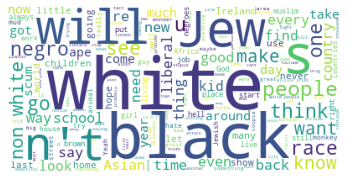

In [9]:
# WordCloud for sentences classified as hate
wc_hate_tr = WordCloud(background_color='white').generate(' '.join(train_df['sentence'][train_df['label']=='hate']))
# Generate plot
plt.imshow(wc_hate_tr)
plt.axis("off")
plt.show()

**Sentences Classified as no Hate Speech**

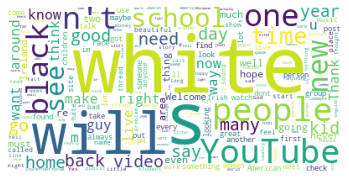

In [10]:
# WordCloud for sentences classified as noHate
wc_noHate_tr = WordCloud(background_color='white').generate(' '.join(train_df['sentence'][train_df['label']=='noHate']))
# Generate plot
plt.imshow(wc_noHate_tr)
plt.axis("off")
plt.show()

#### WordCloud - Test Data

**Sentences Classified as Hate Speech**

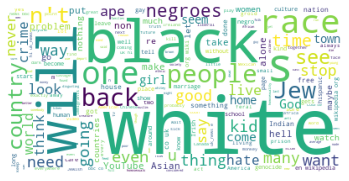

In [11]:
# WordCloud for sentences classified as hate
wc_hate_tst = WordCloud(background_color='white').generate(' '.join(test_df['sentence'][test_df['label']=='hate']))
# Generate plot
plt.imshow(wc_hate_tst)
plt.axis("off")
plt.show()

**Sentences Classified as no Hate Speech**

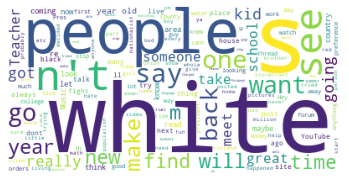

In [12]:
# WordCloud for sentences classified as noHate
wc_noHate_tst = WordCloud(background_color='white').generate(' '.join(test_df['sentence'][test_df['label']=='noHate']))
# Generate plot
plt.imshow(wc_noHate_tst)
plt.axis("off")
plt.show()

The above WordClouds show the most common words found in sentences classified as Hate Speech and No Hate Speech, with both train and test subsets having similar results. 

Words like "black", "white", "Jew", "Asian", "negro", "race", "ape", are few of the most common words found in the WordCloud of Hate Sentences, words that are often found in hate speech language. On the other hand, while words like "black" or "white" also appear in the WordCloud of No Hate Sentences, we can assume that their meaning is not hate speech related, as there are among other seemingly "innocent" words like "YouTube", "shool", "people", "time", "good" and others.

#### Plot class distribution

**Train Subset**

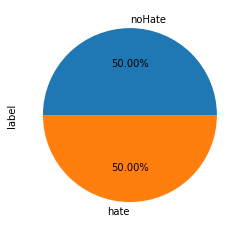

In [13]:
# Plot the class distribution - Train
plot_tr = train_df.label.value_counts().plot(kind='pie',autopct='%1.2f%%')

**Test Subset**

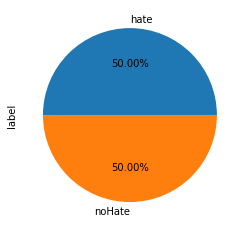

In [14]:
# Plot the class distribution - Test
plot_tst = test_df.label.value_counts().plot(kind='pie',autopct='%1.2f%%')

#### Text Pre-Processing using NLTK
According to their published paper, the owners of the dataset conducted their experimentations without doing any heavy text pre-processing on the sentences. In order to recreate their paper results, a similar approach will be taken, applying only very basic pre-processing on the sentences, like lowercasing and removing punctuation and non-alpha character.

A new "clean_sentence" column will be created for both train and test subsets, containing each processed sentence, using nltk and applying a lambda function to the "sentence" column.

In [15]:
nltk.download('punkt') # NLTK resources for removing punctuation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**Pre-Process the train subset**

In [16]:
# Train Subset
# Create new column and apply pre-processing using nltk
train_df['clean_sentence'] = train_df.sentence.apply(
    lambda text: 
        " ".join(
            word.lower() for word in word_tokenize(text) if word.isalpha()
        )
)

**Pre-Process the test subset**

In [17]:
# Test Subset
# Create new column and apply pre-processing using nltk
test_df['clean_sentence'] = test_df.sentence.apply(
    lambda text: 
        " ".join(
            word.lower() for word in word_tokenize(text) if word.isalpha()
        )
)

## Recreating Paper Results
The purpose of this section is to attempt to recreate the results reported in the dataset owners' paper, in order to use them as a benchmarking tool and compare them with the results of this research.

In the paper, the below three algorithms were used for Hate Speech Classification:

- Support Vector Machines (SVM) over Bag-of-Words vectors. Word-count-based vectors were computed and fed into a Python Scikit-learn LinearSVM classifier to separate Hate and NoHate instances
- Convolutional Neural Networks (CNN). The implementation was a simplified version using a single input channel of randomly initialized word embeddings
- Recurrent Neural Networks with Long Short-term Memory (LSTM). A LSTM layer of size 128 over word embeddings of size 300

All the hyperparameters were left to the usual values reported in the literature. No hyperparameter tuning was performed. A more comprehensive experimentation and research was left for future work.

### Support Vector Machine (SVM)

#### Bag-of-Words Vectors
For the creation of the Bag-of-Words model, CountVectorizer will be used. The first step is to create the vocabulary, which will be created using only the train subset, in order to avoid leaking the test data to the SVM model.

In [21]:
# Instantiate Count Vectorizer
vectorizer = CountVectorizer()

# Create the vocabulary using the train subset
vectorizer.fit(train_df.clean_sentence.to_list())

# Transform train sample to document-term matrix
X_train_mat = vectorizer.transform(train_df.clean_sentence.to_list())
# Create a Pandas DataFrame from the document-term matrix
X_train_df = pd.DataFrame(X_train_mat.toarray(), columns=vectorizer.get_feature_names_out())

# Transform test sample to document-term matrix
X_test_mat = vectorizer.transform(test_df.clean_sentence.to_list())
# Create a dataframe from the document-term matrix
X_test_df = pd.DataFrame(X_test_mat.toarray(),columns=vectorizer.get_feature_names_out())

#### Create and train the SVM Model

In [22]:
# Instatiate SVC
svm = LinearSVC()
# Fit training data
svm.fit(X_train_df, train_df.label)
# Get prediction on test data
svm_pred = svm.predict(X_test_df)

#### Get Accuracy, F1 Score and Confusion Matrix

Accuracy: 0.7322175732217573
F1 Score: 0.727659574468085


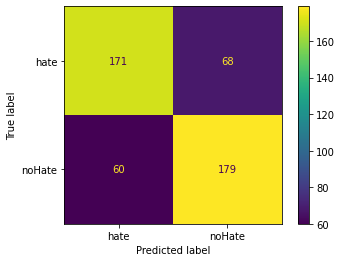

In [23]:
# Print the accuracy
print('Accuracy: '+str(svm.score(X_test_df, test_df.label)))
# Print the F1 Score
print('F1 Score: '+str(f1_score(test_df.label, svm_pred, pos_label='hate')))
# Create confusion matrix
cm = confusion_matrix(test_df.label, svm_pred, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()
plt.show()

Using the sampled train and test data returned an accuracy of 0.73, which is lower than the accuracy I got using the whole dataset. However, the F1 Score is much higher, 0.73, and the model does a fair job in correctly classifying both hate and noHate classes. These results are very close to the results from the paper and indicate the importance of having a class balanced dataset in text classification problems. As a result, the balanced train and test subsets will be used for the rest of the experimentations.

### Convolutional Neural Network (CNN)

In their paper, the owners of the dataset have provided a github repository which includes code for a slightly simplified implementation of Kim's Convolutional Neural Networks for Sentence Classification paper, CNN-rand, written in Tensorflow.

The code below is my implementation of the above, written in Keras.

#### Dataset Preparation
The dataset needs to be prepared before it is used on the CNN Model. First, a vocabulary needs to be created to tokenize the text into number sequences. Second, all sequences must be padded to the same length (max sentence length). Finally, the train and test subset labels have to be one hot encoded.

In [18]:
# Find the highest length between all sentences
max_sent_len = max([len(sent.split(" ")) for sent in train_df.clean_sentence.to_list()])
# Instantiate keras Tokenizer with out of vocabulary token (oov) equal to True
tokenizer = Tokenizer(oov_token=True)
# Create a vocabulary using the train subset
tokenizer.fit_on_texts(train_df.clean_sentence.to_list())

# Convert train subset to list of sequences
X_train_cnn = tokenizer.texts_to_sequences(train_df.clean_sentence.to_list())
# Pad sequences to the same length
X_train_cnn = pad_sequences(X_train_cnn, maxlen=max_sent_len, dtype='float32',
                            padding='post')

# Convert test to sequences
X_test_cnn = tokenizer.texts_to_sequences(test_df.clean_sentence.to_list())
# Pad examples to the same length
X_test_cnn = pad_sequences(X_test_cnn, maxlen=max_sent_len, dtype='float32',
                           padding='post')

# one hot encode train labels
y_train_cnn = pd.get_dummies(train_df.label).values.astype('float32')

# one hot encode test labels
y_test_cnn = pd.get_dummies(test_df.label).values.astype('float32')

#### Set up hyperparameters

In [19]:
# Percentage of the training data to use for validation
val_pct = 0.1
# The size of the embedding layer (Output dimension)
embedding_dim = 128
# Number of filters per filter size
num_filters = 128
# Dropout keep probability
dropout_prob = 0.5
# Batch Size
batch_size = 64
# Number of training epochs
num_epochs = 50

#### Build the model

In [21]:
# Set up parameters for Keras layers
sequence_length = X_train_cnn.shape[1] # Length of input sequences
input_shape = (sequence_length,) # Shape of the Input layer
vocab_size = len(tokenizer.word_index) + 1 # The input dimension of the embedding layer 
num_classes = y_train_cnn.shape[1] # Number of classes for the output layer

# Print layer information
print("Sequence Length: {}".format(sequence_length))
print("Input Shape: {}".format(input_shape))
print("Vocabulary Size: {}".format(vocab_size))
print("Embedding Size: {}".format(embedding_dim))
print("Number of Classes: {}".format(num_classes))

# Create Keras Model Layers
# The Input Layer
inputLayer = Input(shape=input_shape, name='InputLayer')
# One Embedding Layer with randomly initialized word embeddings
embLayer = Embedding(vocab_size, embedding_dim,embeddings_initializer='random_uniform',
                     input_length=sequence_length, name='EmbeddingLayer')(inputLayer)
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer1')(embLayer)
# Three pairs of Convolution and Pool layers, each one flattened
# First Pair, with kernel size 3
pairOneLayer = Conv1D(num_filters, 3, activation='relu',
                      name='ConvLayer1')(dropLayer) # Convolution Layer
pairOneLayer = MaxPooling1D(name='PoolLayer1')(pairOneLayer) # Pooling Layer
pairOneLayer = Flatten(name='FlattenLayer1')(pairOneLayer) # Flatten Layer
# Second Pair, with kernel size 4
pairTwoLayer = Conv1D(num_filters, 4, activation='relu',
                      name='ConvLayer2')(dropLayer) # Convolution Layer
pairTwoLayer = MaxPooling1D(name='PoolLayer2')(pairTwoLayer) # Pooling Layer
pairTwoLayer = Flatten(name='FlattenLayer2')(pairTwoLayer) # Flatten Layer
# Third Pair, with kernel size 5
pairThreeLayer = Conv1D(num_filters, 5, activation='relu',
                      name='ConvLayer3')(dropLayer) # Convolution Layer
pairThreeLayer = MaxPooling1D(name='PoolLayer3')(pairThreeLayer) # Pooling Layer
pairThreeLayer = Flatten(name='FlattenLayer3')(pairThreeLayer) # Flatten Layer
# Concatenate the three pairs
concLayer = Concatenate(name='ConcatLayer')([pairOneLayer,pairTwoLayer,pairThreeLayer])
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer2')(concLayer)
# The Output layer
outputLayer = Dense(num_classes, activation='softmax', name='OutputLayer')(dropLayer)

# Group layers into the Model object
cnn_model = Model(inputLayer, outputLayer)
# Print model summary
cnn_model.summary()

Sequence Length: 323
Input Shape: (323,)
Vocabulary Size: 5549
Embedding Size: 128
Number of Classes: 2
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 323)]        0           []                               
                                                                                                  
 EmbeddingLayer (Embedding)     (None, 323, 128)     710272      ['InputLayer[0][0]']             
                                                                                                  
 DropoutLayer1 (Dropout)        (None, 323, 128)     0           ['EmbeddingLayer[0][0]']         
                                                                                                  
 ConvLayer1 (Conv1D)            (None, 321, 128)     49280       ['DropoutLayer1[0][0]'] 

The Neural Network uses an input layer, one embedding layer of randomly initialized word embeddings, one dropout layer to avoid overfitting. Three pairs of Convolution and Pooling layers, one for each kernel size of 3, 4 and 5, are used to capture the semantic patterns of each sentence, which are then concatenated together. Finally, a second dropout layer is added followed by a dense output layer that classifies each sentence.

#### Visualise the CNN Model
The Keras model can be visualised using the plot_model function from Keras Visualisation Utilities. Visualising the model is a good practice as it helps to confirm layers order and shapes.

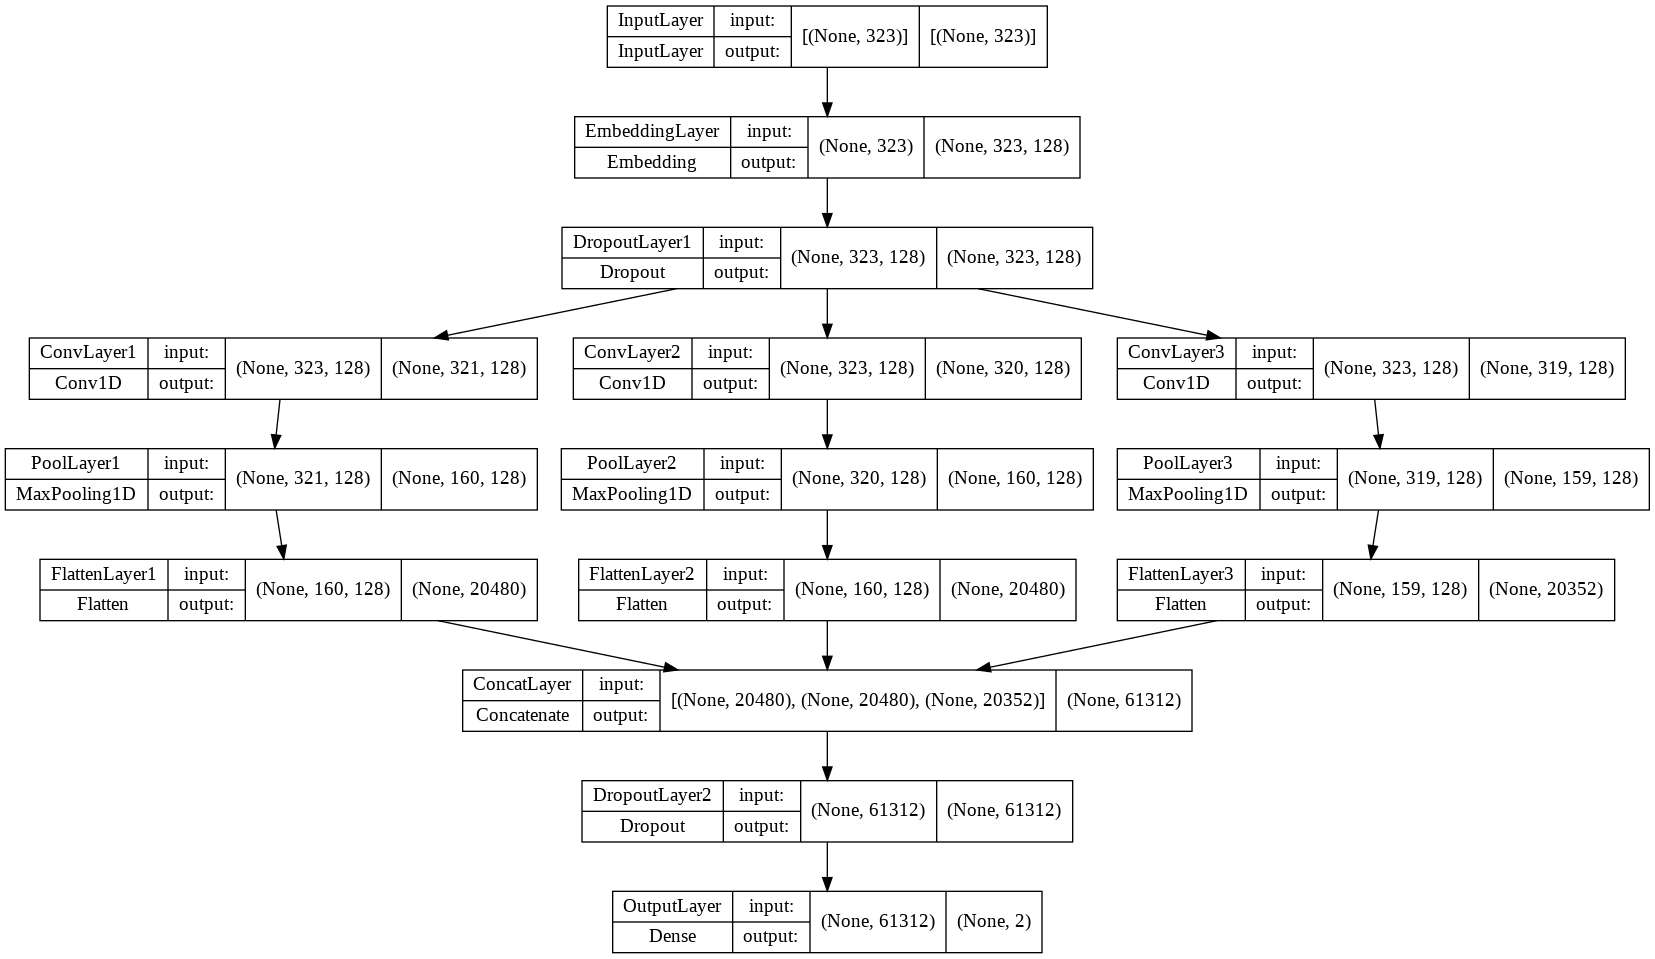

In [31]:
# Import visualisation library
from keras.utils.vis_utils import plot_model
# Plot the model
plot_model(cnn_model, show_shapes=True, show_layer_names=True)

#### Train the CNN Model
The model gets compiled choosing Adam as the preferred optimizer, Categorical Crossentropy as a loss function and Accuracy as a performance metric. The model is then trained on the train subset, saving the training history to be used for plotting performance metrics.

In [24]:
# Specify loss function, optimizer, and performance metrics
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['acc'])

# Train the model and store the history
cnn_history = cnn_model.fit(X_train_cnn, y_train_cnn, batch_size=batch_size,
                            epochs=num_epochs, validation_split=val_pct)

Epoch 1/50
27/27 [==============================] - 3s 26ms/step - loss: 0.6751 - acc: 0.5738 - val_loss: 0.6738 - val_acc: 0.6042
Epoch 2/50
27/27 [==============================] - 0s 15ms/step - loss: 0.5988 - acc: 0.6800 - val_loss: 0.6073 - val_acc: 0.6615
Epoch 3/50
27/27 [==============================] - 0s 15ms/step - loss: 0.4540 - acc: 0.7863 - val_loss: 0.5662 - val_acc: 0.7292
Epoch 4/50
27/27 [==============================] - 0s 15ms/step - loss: 0.2810 - acc: 0.8908 - val_loss: 0.5897 - val_acc: 0.7552
Epoch 5/50
27/27 [==============================] - 0s 15ms/step - loss: 0.1387 - acc: 0.9547 - val_loss: 0.7387 - val_acc: 0.7448
Epoch 6/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0696 - acc: 0.9814 - val_loss: 0.9044 - val_acc: 0.7500
Epoch 7/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0413 - acc: 0.9919 - val_loss: 0.9670 - val_acc: 0.7396
Epoch 8/50
27/27 [==============================] - 0s 14ms/step - loss: 0.0281 - a

#### Plot the model's training history
Using the training history dictionary, the accuracy and loss can be plotted to observe the model's performance during training.

**Load the training and validation accuracy and loss from the training history**

In [25]:
# Load the history dictionary
cnn_hist_dict = cnn_history.history
# Store the performance metrics
cnn_acc = cnn_hist_dict['acc'] # Accuracy
cnn_val_acc = cnn_hist_dict['val_acc'] # Validation Accuracy
cnn_loss = cnn_hist_dict['loss'] # Loss
cnn_val_loss = cnn_hist_dict['val_loss'] # Validation Loss
# Get the number of epochs
epochs = range(1, len(cnn_acc) + 1)

**Plot training and validation loss**

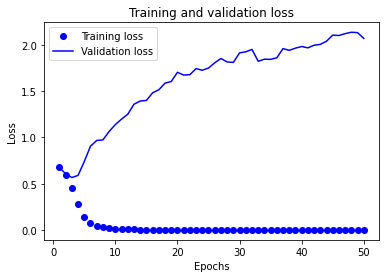

In [26]:
# Training and validation loss
plt.plot(epochs, cnn_loss, 'bo', label='Training loss') # Training Loss
plt.plot(epochs, cnn_val_loss, 'b', label='Validation loss') # Validation Loss
# Set title and labels
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Plot training and validation accuracy**

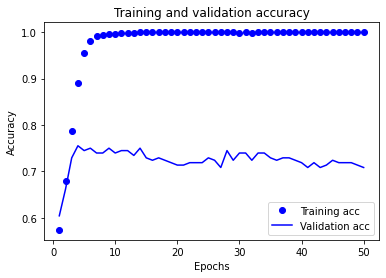

In [27]:
# Clear current figure
plt.clf()
# Training and validation accuracy
plt.plot(epochs, cnn_acc, 'bo', label='Training acc') # Training Accuracy
plt.plot(epochs, cnn_val_acc, 'b', label='Validation acc') # Validation Accuracy
# Set title and labels
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

#### Test the CNN model
The trained model will be tested on the test subset, measuring its performance using the accuracy, F1 Score and Confusion Matrix metrics.

Evaluate on test data
15/15 [==============================] - 0s 5ms/step - loss: 1.7910 - acc: 0.7531
Model Loss, Model Accuracy: [1.7909845113754272, 0.7531380653381348]
F1 Score: 0.7489361702127659


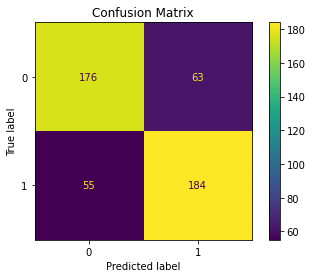

In [34]:
# Evaluate the model on the test subset
print("Evaluate on test data")
cnn_results = cnn_model.evaluate(X_test_cnn, y_test_cnn)
print("Model Loss, Model Accuracy:", cnn_results)

# Store the predictions to be used for the F1 Score and the Confusion Matrix
cnn_pred = cnn_model.predict(X_test_cnn)
# Convert pred to boolean
y_pred_bool = np.argmax(cnn_pred, axis=1)
# Convert the categorical label to numeric
y_test_cnn_num = test_df.label.replace(['hate','noHate'],[0,1])

# Print the F1 Score
print('F1 Score: '+str(f1_score(y_test_cnn_num, y_pred_bool, pos_label=0)))

# Print the Confusion Matrix
cm = confusion_matrix(y_test_cnn_num, y_pred_bool) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # Generate CM Display
disp.plot()
plt.title('CNN Confusion Matrix') # Set Title
# Show the plot
plt.show()

### Long Short-Term Memory (LSTM)

#### Dataset Preparation
Similarly to the CNN steps, the dataset needs to be prepared before it is used on the LSTM Model. There is an important difference in regards to sequence padding. Initially, post-padding was used, similarly to the CNN model. However, the LSTM performance was negatively affected, classifying all sentences into the *hate* class, returning an accuracy of 50%. The LSTM model works only with pre-padding, since post-padding adds noise to the sequences, preventing the model from learning. 

In [35]:
# Find the highest length between all sentences
max_sent_len = max([len(sent.split(" ")) for sent in train_df.clean_sentence.to_list()])
# Instantiate keras Tokenizer with out of vocabulary token (oov) equal to True
tokenizer = Tokenizer(oov_token=True)
# Create a vocabulary using the train subset
tokenizer.fit_on_texts(train_df.clean_sentence.to_list())

# Convert train subset to list of sequences
X_train_lstm = tokenizer.texts_to_sequences(train_df.clean_sentence.to_list())
# Pad sequences to the same length
X_train_lstm = pad_sequences(X_train_lstm, maxlen=max_sent_len, dtype='float32',
                            padding='pre')

# Convert test to sequences
X_test_lstm = tokenizer.texts_to_sequences(test_df.clean_sentence.to_list())
# Pad examples to the same length
X_test_lstm = pad_sequences(X_test_lstm, maxlen=max_sent_len, dtype='float32',
                           padding='pre')

# one hot encode train labels
y_train_lstm = pd.get_dummies(train_df.label).values.astype('float32')

# one hot encode test labels
y_test_lstm = pd.get_dummies(test_df.label).values.astype('float32')

#### Set up hyperparameters

In [39]:
# Percentage of the training data to use for validation
dev_sample_percentage = 0.1
# Dimensionality of character embedding (default: 300)
embedding_dim = 300
# LSTM Layer size
lstm_dim = 128
# Batch Size (default: 64)
batch_size = 64
# Number of training epochs (default: 200)
num_epochs = 50

#### Build the model

In [40]:
# Create the LSTM Model
sequence_length = X_train_lstm.shape[1]
num_classes = y_train_lstm.shape[1]
vocab_size = len(tokenizer.word_index) + 1
embedding_size = embedding_dim

print("Sequence Length: {}".format(sequence_length))
print("Number of Classes: {}".format(num_classes))
print("Vocabulary Size: {}".format(vocab_size))
print("Embedding Size: {}".format(embedding_size))

lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, 300, input_length=sequence_length))
lstm_model.add(LSTM(lstm_dim))
lstm_model.add(Dense(num_classes, activation='softmax'))

print(lstm_model.summary())

Sequence Length: 323
Number of Classes: 2
Vocabulary Size: 5549
Embedding Size: 300
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 323, 300)          1664700   
                                                                 
 lstm_1 (LSTM)               (None, 128)               219648    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 1,884,606
Trainable params: 1,884,606
Non-trainable params: 0
_________________________________________________________________
None


#### Preparing the training process

In [41]:
# Specify loss function and optimizer

lstm_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

#### Train the LSTM Model

In [42]:
lstm_history = lstm_model.fit(X_train_lstm,
                    y_train_lstm,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_split=dev_sample_percentage)

Epoch 1/50
27/27 [==============================] - 4s 46ms/step - loss: 0.6330 - acc: 0.6423 - val_loss: 0.6146 - val_acc: 0.6510
Epoch 2/50
27/27 [==============================] - 1s 26ms/step - loss: 0.4276 - acc: 0.8026 - val_loss: 0.5407 - val_acc: 0.7188
Epoch 3/50
27/27 [==============================] - 1s 27ms/step - loss: 0.1651 - acc: 0.9425 - val_loss: 0.7035 - val_acc: 0.7083
Epoch 4/50
27/27 [==============================] - 1s 27ms/step - loss: 0.0626 - acc: 0.9826 - val_loss: 0.8480 - val_acc: 0.6927
Epoch 5/50
27/27 [==============================] - 1s 27ms/step - loss: 0.0244 - acc: 0.9965 - val_loss: 0.9133 - val_acc: 0.7240
Epoch 6/50
27/27 [==============================] - 1s 27ms/step - loss: 0.0124 - acc: 0.9983 - val_loss: 1.1569 - val_acc: 0.7135
Epoch 7/50
27/27 [==============================] - 1s 27ms/step - loss: 0.0042 - acc: 1.0000 - val_loss: 1.2707 - val_acc: 0.7083
Epoch 8/50
27/27 [==============================] - 1s 27ms/step - loss: 0.0017 - a

#### Plot the training history

Load acc and loss from history

In [ ]:
lstm_history_dict = lstm_history.history

lstm_acc = lstm_history_dict['acc']
lstm_val_acc = lstm_history_dict['val_acc']
lstm_loss = lstm_history_dict['loss']
lstm_val_loss = lstm_history_dict['val_loss']

epochs = range(1, len(lstm_acc) + 1)

Training and validation loss

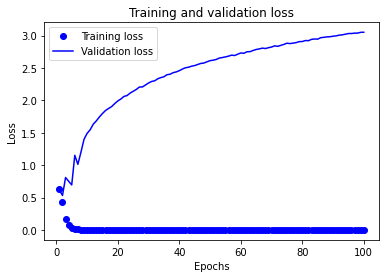

In [ ]:
# Training and validation loss
plt.plot(epochs, lstm_loss, 'bo', label='Training loss')
plt.plot(epochs, lstm_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Training and validation accuracy

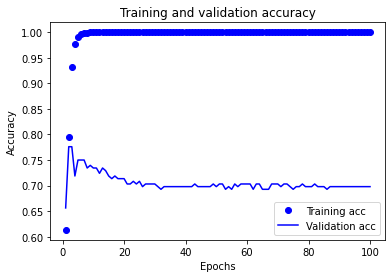

In [ ]:
plt.clf()   # clear figure
# Training and validation accuracy
plt.plot(epochs, lstm_acc, 'bo', label='Training acc')
plt.plot(epochs, lstm_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Test the LSTM Model
Test the model on the sampled test data. Print the Accuracy, F1 Score and Confusion Matrix

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = lstm_model.evaluate(x_test_lstm, y_test_lstm)
print("test loss, test acc:", results)
pred = lstm_model.predict(x_test_lstm)

Evaluate on test data
15/15 [==============================] - 1s 13ms/step - loss: 2.9972 - acc: 0.7113
test loss, test acc: [2.9972434043884277, 0.7112970948219299]


F1 Score: 0.7125


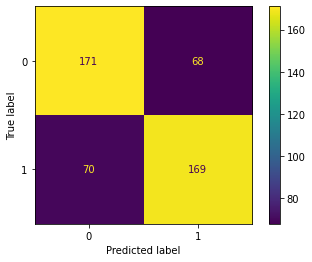

In [ ]:
# Convert pred to boolean
y_pred_bool = pred.argmax(-1)

# Convert categorical label to numeric
y_test_lstm_num = test_df.label.replace(['hate','noHate'],[0,1])

# Get F1 Score and Confusion Matrix
# Print the F1 Score
print('F1 Score: '+str(f1_score(y_test_lstm_num, y_pred_bool, pos_label=0)))
# Create confusion matrix
cm = confusion_matrix(y_test_lstm_num, y_pred_bool)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()